In [1]:
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets, models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from __future__ import print_function, division
import os
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
from torch.utils.data import random_split
from torch.autograd import Variable
import time
import copy
torch.manual_seed(1)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Download CIFAR


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
45000 5000
Files already downloaded and verified
10000


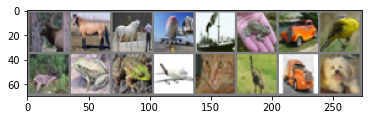

In [2]:
batch_size = 16

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_size = 5000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
print(len(trainset), len(valset))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(testset))
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(" ".join('%s' %classes[labels[j]] for j in range(batch_size)))

Use pre-trained resnet and do transfer learning. 

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
  begin = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    for phase in ['train', 'val']:
      if phase == 'train':
        model = model.train()
      else:
        model = model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      dataloader = trainloader if phase == 'train' else valloader
      for inputs, labels in dataloader:
         inputs = inputs.to(device)
         labels = labels.to(device)
         optimizer.zero_grad()
         with torch.set_grad_enabled(phase == 'train'):
           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)
           loss = criterion(outputs, labels)
           if phase == 'train':
             loss.backward()
             optimizer.step()

         running_loss += loss.item() * inputs.size(0)
         running_corrects += torch.sum(preds == labels.data)
      if phase == 'train':
        scheduler.step()
      size = val_size if phase == "val" else train_size
      epoch_loss = running_loss / size
      epoch_acc = running_corrects.double() / size

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

        print()
  time_elapsed = time.time() - begin
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  model.load_state_dict(best_model_wts)
  return model

resnet_model = models.resnet18(pretrained=True)
print(resnet_model.fc.out_features)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(classes))
resnet_model = resnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
resnet_model = train_model(resnet_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)


deer horse horse plane ship frog car bird deer frog frog plane cat bird truck dog


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

1000
Epoch 0/9
train Loss: 1.1293 Acc: 0.6181
val Loss: 0.7647 Acc: 0.7386

Epoch 1/9
train Loss: 0.7671 Acc: 0.7415
val Loss: 0.6523 Acc: 0.7802

Epoch 2/9
train Loss: 0.6290 Acc: 0.7851
val Loss: 0.5941 Acc: 0.8028

Epoch 3/9
train Loss: 0.5273 Acc: 0.8200
val Loss: 0.5920 Acc: 0.8004
Epoch 4/9
train Loss: 0.4442 Acc: 0.8488
val Loss: 0.6055 Acc: 0.8006
Epoch 5/9
train Loss: 0.3779 Acc: 0.8711
val Loss: 0.5247 Acc: 0.8242

Epoch 6/9
train Loss: 0.3294 Acc: 0.8858
val Loss: 0.5647 Acc: 0.8162
Epoch 7/9
train Loss: 0.1856 Acc: 0.9372
val Loss: 0.5110 Acc: 0.8306

Epoch 8/9
train Loss: 0.1470 Acc: 0.9507
val Loss: 0.5193 Acc: 0.8340

Epoch 9/9
train Loss: 0.1253 Acc: 0.9580
val Loss: 0.5245 Acc: 0.8364

Training complete in 6m 34s


Test model on test dataset


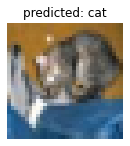

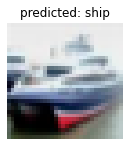

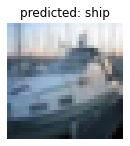

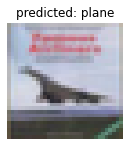

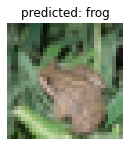

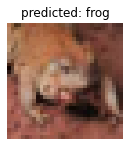

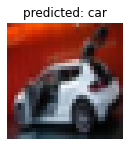

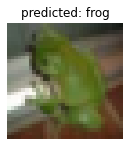

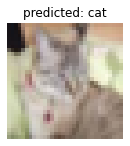

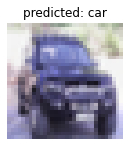

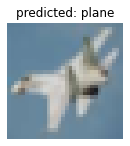

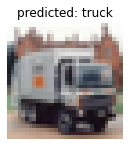

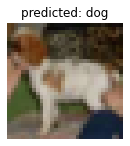

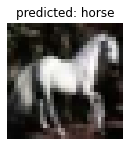

In [4]:
resnet_model = resnet_model.eval()

plt.rcParams["figure.figsize"] = (40,20)
fig = plt.figure()
num_images = 16
with torch.no_grad():
  img_count = 0
  for i, (inputs, labels) in enumerate(testloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = resnet_model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(inputs.size()[0]):
      img_count += 1
      if img_count >= num_images - 1:
        break
      ax = plt.subplot(num_images//2, 2, img_count)
      ax.axis('off')
      ax.set_title('predicted: {}'.format(classes[preds[j]]))
      imshow(inputs.cpu().data[j])

     


Deep Fool on few images

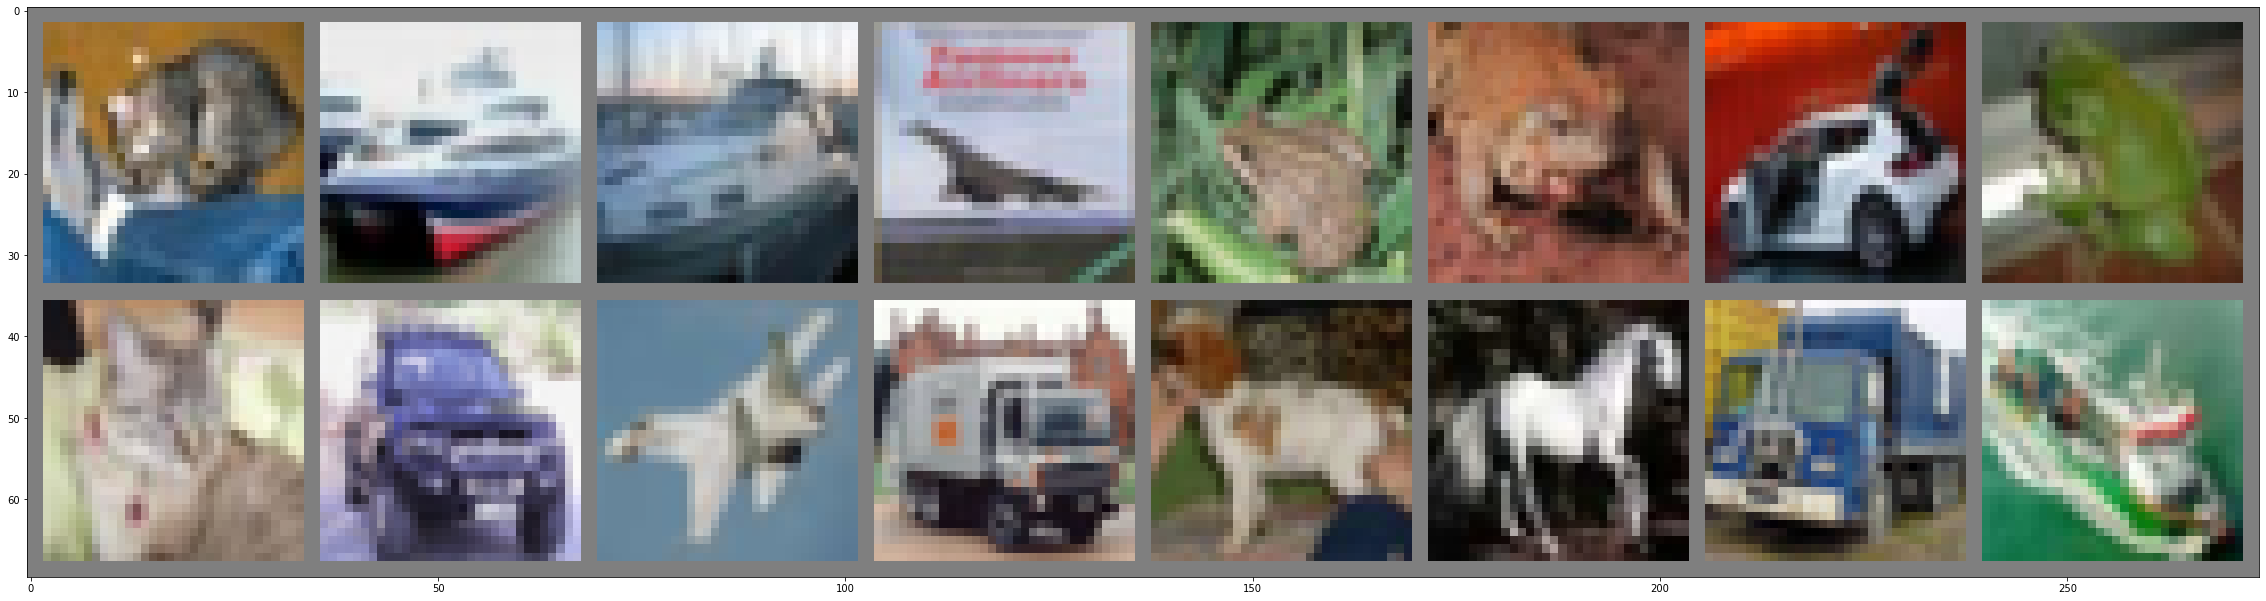

cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship
torch.Size([3, 32, 32])
(1, 3, 32, 32)
car


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


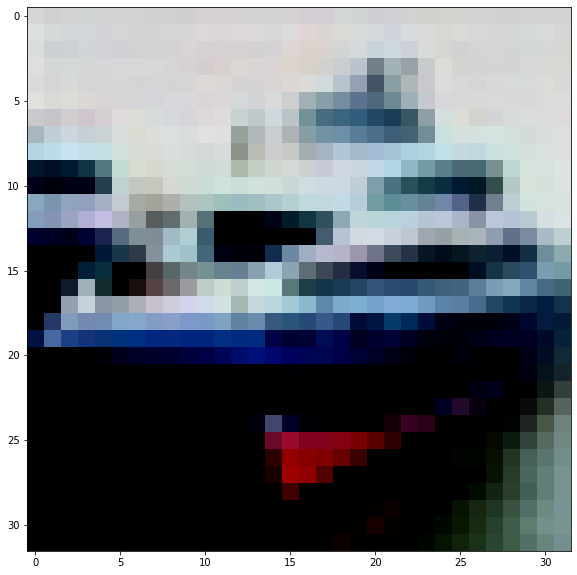

In [5]:
#DeepFool
def deepfool(image, net, device, num_classes=10, overshoot=0.02, max_iter=50):

    """
       :param image: Image of size HxWx3
       :param net: network (input: images, output: values of activation **BEFORE** softmax).
       :param num_classes: num_classes (limits the number of classes to test against, by default = 10)
       :param overshoot: used as a termination criterion to prevent vanishing updates (default = 0.02).
       :param max_iter: maximum number of iterations for deepfool (default = 50)
       :return: minimal perturbation that fools the classifier, number of iterations that it required, new estimated_label and perturbed image
    """
    image = image.to(device)
    net = net.to(device)

    f_image = net.forward(image.unsqueeze(0)).detach().cpu().numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]

    I = I[0:num_classes]
    label = I[0]

    input_shape = image.shape
    pert_image = image

    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0

    x = pert_image.unsqueeze(0)
    x.requires_grad_()

    fs = net.forward(x)
    fs_list = [fs[0,I[k]] for k in range(num_classes)]
    k_i = label

    while k_i == label and loop_i < max_iter:

        pert = np.inf
        fs[0, I[0]].backward(retain_graph=True)
        grad_orig = x.grad.data.cpu().numpy().copy()

        for k in range(1, num_classes):
            x.grad.zero_()

            fs[0, I[k]].backward(retain_graph=True)
            cur_grad = x.grad.data.cpu().numpy().copy()

            # set new w_k and new f_k
            w_k = cur_grad - grad_orig
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

            pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

            # determine which w_k to use
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # compute r_i and r_tot
        r_i =  pert * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1+overshoot)*torch.from_numpy(r_tot).to(device)

        x = pert_image
        x.requires_grad_()
        fs=net.forward(x)
        k_i = np.argmax(fs.data.cpu().numpy().flatten())

        loop_i += 1

    r_tot = (1+overshoot)*r_tot

    return r_tot, loop_i, label, k_i, pert_image


dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(" ".join('%s' %classes[labels[j]] for j in range(batch_size)))
print(images[0].shape)

plt.rcParams["figure.figsize"] = (10,10)

images, labels = images.to(device), labels.to(device)
resnet_model = resnet_model.to(device)
r,i,label,k, pert = deepfool(images[1], resnet_model, device, len(classes))
print(r.shape)
output = resnet_model(pert)
forwarded_image = np.array(output.detach().cpu()).flatten()
I = (np.array(forwarded_image)).flatten().argsort()[::-1]
I = I[0:len(classes)]
label = I[0]
print(classes[label])
r = r.squeeze()
plt.imshow(np.transpose(r, (1, 2, 0)))
pert_img = pert.squeeze().detach().cpu()
plt.imshow(np.transpose(pert_img, (1, 2, 0)))



Get fooling rate

In [6]:
def fooling_rate(dataloader, pert, net):
  fooled_imgs = 0
  total_imgs = len(dataloader.dataset)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = net(inputs)
      _, preds = torch.max(outputs, 1)
      outputs_pret = net(inputs + pert)
      _, preds_pert = torch.max(outputs_pret, 1)
      for j in range(inputs.size()[0]):
        if preds[j] != preds_pert[j]:
          fooled_imgs += 1
  return fooled_imgs/total_imgs


def projection(pert, xi, p):
    # Project on the lp ball centered at 0 and of radius xi
    if p==np.inf:
      pert = torch.clamp(pert,-xi,xi)
    else:
      pert = pert * min(1, xi/(torch.norm(pert,p)+0.00001))
    return pert

Universal Perturbation

In [9]:
def universal_perturbation(trainloader, valloader, net, device, fooling_accuracy=0.2, no_iters = 10, num_classes=10, overshoot=0.02, xi=10, p=np.inf):
  current_fooling_accuracy = 0  
  iter = 0
  pert = torch.zeros(1,3,32,32).to(device)
  pert.requires_grad_()
  while current_fooling_accuracy < 1 - fooling_accuracy and iter < no_iters:
    for i, (inputs, labels) in enumerate(valloader):     
      for j in range(inputs.size()[0]):
          input = inputs[j].to(device)
          label = labels[j].to(device)
          output = net(input.unsqueeze(0))          
          _, preds = torch.max(output, 1)
          output_pret = net(input.unsqueeze(0) + pert)
          _, preds_pert = torch.max(output_pret, 1)
          if torch.equal(preds, preds_pert):
            pert_tot, _, _, _, _ = deepfool(inputs[j], net, device, num_classes, overshoot, no_iters)
            pert_tot_tensor = torch.from_numpy(pert_tot)
            pert = projection(pert + pert_tot_tensor.to(device), xi, p)
    #deepfool(image, net, device, num_classes=10, overshoot=0.02, max_iter=50):
    current_fooling_accuracy = fooling_rate(valloader, pert, net)
    if iter % 10 == 0:
      print(current_fooling_accuracy)
    iter = iter + 1
  return pert

In [10]:
for i, (inputs, labels) in enumerate(valloader):
   for j in range(inputs.size()[0]):
        print(inputs[j].size())
        input = inputs[j].to(device)
        label = labels[j].to(device)
        outputs = resnet_model(input.unsqueeze(0))
        _, preds = torch.max(outputs, 1)
        print(preds)
        break
   break
pert = universal_perturbation(trainloader, valloader, resnet_model, device, 0.2, 100)

torch.Size([3, 32, 32])
tensor([6], device='cuda:0')
0.8056


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


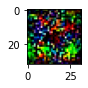

In [14]:
plt.rcParams["figure.figsize"] = (1,1)
pert = pert.squeeze(0)
print(pert.shape)
plt.imshow(pert.detach().cpu().permute(1, 2, 0))